# Part 2: Prediction and DPM Generation

This notebook implements the LSTM-based prediction model and damage score calculation:

1. **LSTM Model** - Neural network for time series forecasting
   - Dataset preparation with temporal feature extraction
   - Model training and optimization
   - Prediction of expected phase standard deviation

2. **Damage Score Calculation** - Computing normalized difference between observed and predicted values

## Input Files
- `data.npy` - Pre-event coherence time series
- `data_std.npy` - Pre-event phase standard deviation
- `geninue_std.npy` - Observed co-event phase standard deviation
- `dates.pkl` - Temporal information

## Output Files
- `future_predictions.npy` - Predicted phase standard deviation
- `lstm_model.pth` - Trained model weights
- `score.npy` - Damage score array

---

# InSAR Time Series Prediction Using LSTM

This script utilizes a Long Short-Term Memory (LSTM) neural network to predict future values of InSAR (Interferometric Synthetic Aperture Radar) time series data. The model is trained on historical InSAR data and can forecast future data points. The workflow includes dataset preparation, model training, prediction, and saving the results.

## Key Features

1. **InSAR Dataset Preparation**:

   * The `InSARDataset` class is used to load and preprocess the InSAR time series data. It normalizes the data for each pixel and extracts temporal features (such as year, month, and day) for the LSTM model to learn from.

2. **LSTM Model for Time Series Forecasting**:

   * The `InSARLSTM` class defines an LSTM-based model that takes past time steps as input and predicts future values. It also incorporates temporal features to improve predictions.

3. **Training**:

   * The model is trained using the Mean Squared Error (MSE) loss function and the Adam optimizer. The training data is split into a training set and validation set for model evaluation.

4. **Prediction**:

   * After training, the model is used to predict future time points based on the last available time step. The results are saved in a specified directory.

5. **Visualization**:

   * The last available time point and the predicted future time point are visualized using Matplotlib.

6. **Saving Results**:

   * The trained model and prediction results are saved for future use. The prediction is stored as a `.npy` file, and the trained model is saved as a PyTorch model file.

## Workflow

1. **Load Data**:

   * The InSAR time series data is loaded from a `.npy` file, and the corresponding dates are loaded from a `.pkl` file.

2. **Prepare Dataset**:

   * The data is passed to the `InSARDataset` class, where each pixel's time series is normalized and temporal features are calculated.

3. **Train the Model**:

   * The LSTM model is trained on the data for a specified number of epochs. The model's weights are saved if the validation loss improves.

4. **Make Predictions**:

   * The trained model is used to predict the next time point. These predictions are saved for future analysis.

5. **Visualize Predictions**:

   * The last time point and predicted future time point are visualized side by side.

## Example Directory Structure

```
/data6/WORKDIR/AmatriceSenDT22/
├── merged/
│   ├── interferograms/
│   │   ├── cropped/   # Contains cropped coherence files
│   ├── interferograms/cropped/dataset/   # Dataset folder containing data and dates
│   ├── interferograms/cropped/predict/   # Folder for saving predictions
```



2025-12-03 12:51:37,548 - matplotlib - DEBUG - matplotlib data path: /home/yangyc/.conda/envs/isce_env/lib/python3.8/site-packages/matplotlib/mpl-data
2025-12-03 12:51:37,558 - matplotlib - DEBUG - CONFIGDIR=/home/yangyc/.config/matplotlib
2025-12-03 12:51:37,561 - matplotlib - DEBUG - interactive is False
2025-12-03 12:51:37,562 - matplotlib - DEBUG - platform is linux
2025-12-03 12:51:37,640 - matplotlib - DEBUG - CACHEDIR=/home/yangyc/.cache/matplotlib
2025-12-03 12:51:37,644 - matplotlib.font_manager - DEBUG - Using fontManager instance from /home/yangyc/.cache/matplotlib/fontlist-v330.json
Using device: cpu
Data shape: (110, 540, 9)
Loaded dates: ['20160306_20160330', '20160330_20160517', '20160517_20160529', '20160529_20160610', '20160610_20160704', '20160704_20160716', '20160716_20160728', '20160728_20160809', '20160809_20160821']
Epoch 1/15, Train Loss: 0.4443, Val Loss: 0.4325
Epoch 2/15, Train Loss: 0.3844, Val Loss: 0.3174
Epoch 3/15, Train Loss: 0.3287, Val Loss: 0.3098
Epo

/tmp/ipykernel_107036/1314957476.py:267: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Prediction results saved to: /data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/predict/future_predictions.npy
Trained model saved to: /data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/predict/best_model.pth


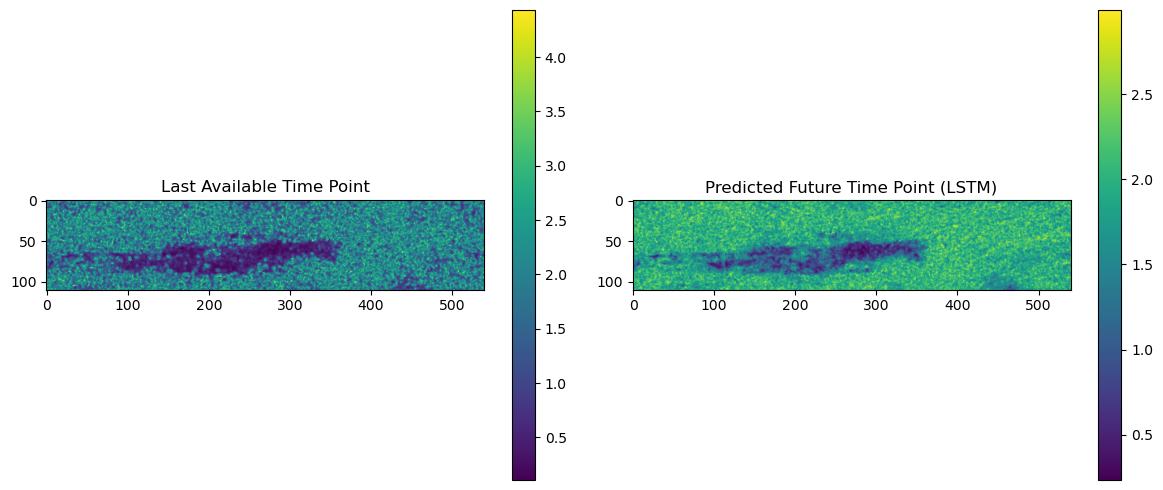

Prediction results saved successfully!


In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import datetime
import matplotlib.pyplot as plt
import logging
from sklearn.preprocessing import MinMaxScaler
import pickle
import os

# Suppress Matplotlib debug messages
logging.getLogger('matplotlib').setLevel(logging.WARNING)
# ============================================================
# 1. Import Libraries
# ============================================================

# ============================================================
# 2. Dataset Definition
# ============================================================
class InSARDataset(Dataset):
    """
    Custom dataset for InSAR time series.

    Args:
        data (numpy.ndarray): InSAR timeseries, shape (H, W, T).
        dates (list[str]): List of interferogram intervals, e.g. ["20150815_20150827", ...].
        window_size (int): Temporal window size. Default: 20.
        is_prediction (bool): If True, builds dataset for forecasting the next step.
    """
    def __init__(self, data, dates, window_size=20, is_prediction=False):
        self.data = data
        self.height, self.width, self.time_steps = data.shape
        self.window_size = window_size
        self.is_prediction = is_prediction

        # ---- Extract temporal features ----
        self.time_features = []
        for date_str in dates:
            start_date, end_date = date_str.split('_')
            start = datetime.datetime.strptime(start_date, '%Y%m%d')
            end = datetime.datetime.strptime(end_date, '%Y%m%d')

            year_sin = np.sin(2 * np.pi * start.year / 2100)
            year_cos = np.cos(2 * np.pi * start.year / 2100)
            month_sin = np.sin(2 * np.pi * start.month / 12)
            month_cos = np.cos(2 * np.pi * start.month / 12)
            day_sin = np.sin(2 * np.pi * start.day / 31)
            day_cos = np.cos(2 * np.pi * start.day / 31)
            interval = (end - start).days

            self.time_features.append([year_sin, year_cos, month_sin, month_cos,
                                       day_sin, day_cos, interval])
        self.time_features = np.array(self.time_features)

        # ---- Normalize each pixel individually ----
        self.scalers = {}
        self.scaled_data = np.zeros_like(self.data, dtype=np.float32)

        for i in range(self.height):
            for j in range(self.width):
                pixel_ts = self.data[i, j, :]
                scaler = MinMaxScaler(feature_range=(-1, 1))
                self.scaled_data[i, j, :] = scaler.fit_transform(pixel_ts.reshape(-1, 1)).flatten()
                self.scalers[(i, j)] = scaler

        # ---- Build sample indices ----
        self.samples = [(i, j) for i in range(self.height) for j in range(self.width)]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        i, j = self.samples[idx]
        pixel_ts = self.scaled_data[i, j, :]

        if not self.is_prediction:  # Training
            x = pixel_ts[:-1]  # first T-1 steps
            y = pixel_ts[-1]   # last step
            time_feat = self.time_features[:-1]
            target_time_feat = self.time_features[-1]
        else:  # Prediction
            x = pixel_ts
            y = 0.0  # placeholder
            time_feat = self.time_features[:self.time_steps]
            target_time_feat = self.time_features[-1]

        return {
            'pixel_coords': torch.tensor([i, j]),
            'x': torch.tensor(x, dtype=torch.float32),
            'time_features': torch.tensor(time_feat, dtype=torch.float32),
            'target_time_features': torch.tensor(target_time_feat, dtype=torch.float32),
            'y': torch.tensor(y, dtype=torch.float32)
        }

# ============================================================
# 3. LSTM Model
# ============================================================
class InSARLSTM(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, num_layers=2, dropout=0.1, time_feat_dim=7):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.input_embedding = nn.Linear(input_dim, hidden_dim)
        self.time_embedding = nn.Linear(time_feat_dim, hidden_dim)

        self.lstm = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        self.target_time_proj = nn.Linear(time_feat_dim, hidden_dim)

        self.output_layer = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, src, time_features, target_time_features):
        batch_size = src.size(0)
        src = src.unsqueeze(-1)  # [B, T, 1]
        src = self.input_embedding(src)  # [B, T, H]
        time_embed = self.time_embedding(time_features)  # [B, T, H]

        combined_input = src + time_embed
        lstm_out, (h_n, c_n) = self.lstm(combined_input)
        seq_repr = h_n[-1]  # last hidden state

        target_time_embed = self.target_time_proj(target_time_features)
        combined = torch.cat([seq_repr, target_time_embed], dim=-1)

        output = self.output_layer(combined)
        return output.squeeze(-1)

# ============================================================
# 4. Training and Prediction Utilities
# ============================================================
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, device='cuda'):
    model.to(device)
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            x = batch['x'].to(device)
            time_features = batch['time_features'].to(device)
            target_time_features = batch['target_time_features'].to(device)
            y = batch['y'].to(device)

            optimizer.zero_grad()
            outputs = model(x, time_features, target_time_features)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * x.size(0)
        train_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                x = batch['x'].to(device)
                time_features = batch['time_features'].to(device)
                target_time_features = batch['target_time_features'].to(device)
                y = batch['y'].to(device)

                outputs = model(x, time_features, target_time_features)
                loss = criterion(outputs, y)
                val_loss += loss.item() * x.size(0)
        val_loss /= len(val_loader.dataset)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')

    return model


def predict_future(model, dataset, device='cuda'):
    model.eval()
    predictions = np.zeros((dataset.height, dataset.width))
    dataloader = DataLoader(dataset, batch_size=256, shuffle=False)

    with torch.no_grad():
        for batch in dataloader:
            coords = batch['pixel_coords'].numpy()
            x = batch['x'].to(device)
            time_features = batch['time_features'].to(device)
            target_time_features = batch['target_time_features'].to(device)

            outputs = model(x, time_features, target_time_features)
            for i in range(len(coords)):
                pixel_i, pixel_j = coords[i]
                scaler = dataset.scalers[(pixel_i, pixel_j)]
                predictions[pixel_i, pixel_j] = scaler.inverse_transform(
                    outputs[i].cpu().numpy().reshape(-1, 1))[0, 0]

    return predictions

# ============================================================
# 5. Save Prediction Results
# ============================================================
def save_predict_results(predictions, model, output_path):
    os.makedirs(output_path, exist_ok=True)

    # Save predictions
    predict_data_path = os.path.join(output_path, "future_predictions.npy")
    np.save(predict_data_path, predictions)
    print(f"Prediction results saved to: {predict_data_path}")

    # Save the trained model
    model_path = os.path.join(output_path, "best_model.pth")
    torch.save(model.state_dict(), model_path)
    print(f"Trained model saved to: {model_path}")

# ============================================================
# 6. Example Usage
# ============================================================

# ---- Device ----
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ============================================================
# Load Data and Dates
# ============================================================

# ---- Data ----
data_path = "/data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/dataset/data_std.npy"   # <-- replace with your file path
data = np.load(data_path)
print(f"Data shape: {data.shape}")   # should be (H, W, T)

# ---- Load Dates from Pickle ----
with open('/data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/dataset/dates.pkl', 'rb') as f:
    dates = pickle.load(f)

print(f"Loaded dates: {dates}")

# ---- Dataset ----
full_dataset = InSARDataset(data, dates)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# ---- Model ----
model = InSARLSTM(input_dim=1, hidden_dim=64, num_layers=2, dropout=0.1, time_feat_dim=7)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ---- Train ----
model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=15, device=device)

# ---- Load Best Model ----
model.load_state_dict(torch.load('best_model.pth'))

# ---- Predict ----
next_date = "20160821_20160902"
all_dates = dates + [next_date]
predict_dataset = InSARDataset(data, all_dates, is_prediction=True)

future_predictions = predict_future(model, predict_dataset, device)

# ---- Save the Prediction Results ----
predict_output_subfolder = os.path.join(output_dir, "predict")
save_predict_results(future_predictions, model, predict_output_subfolder)

# ---- Visualization ----
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(data[:, :, -1], cmap='viridis')
plt.colorbar()
plt.title('Last Available Time Point')

plt.subplot(1, 2, 2)
plt.imshow(future_predictions, cmap='viridis')
plt.colorbar()
plt.title('Predicted Future Time Point (LSTM)')

plt.tight_layout()
plt.savefig('prediction.png')
plt.show()

print("Prediction results saved successfully!")


# Normalized Difference Score Calculation for InSAR Data

This script computes the normalized difference score between two InSAR datasets: `geninue_std` (standard deviation of post-earthquake data) and `future_predictions` (predicted post-earthquake values). The calculation is performed using a block-wise approach to reduce memory usage when dealing with large data arrays. The resulting difference map is saved and visualized for further analysis.

## Key Features

1. **Normalized Difference Calculation**:

   * The script calculates the normalized difference between the two input datasets (`geninue_std` and `future_predictions`), which helps assess the changes or discrepancies between the observed and predicted post-earthquake values.

2. **Block-wise Processing**:

   * To manage large data, the difference is calculated in smaller chunks. This method ensures that memory usage remains manageable even when working with large interferogram data.

3. **Data Loading**:

   * The script loads the `geninue_std.npy` (standard deviation of post-earthquake InSAR data) and `future_predictions.npy` (predicted post-earthquake data) from specified file paths.

4. **Masking**:

   * Invalid pixels (NaN or zero values) are masked and excluded from the calculation, ensuring that these values do not affect the final score.

5. **Saving Results**:

   * The calculated difference score is saved as `score.npy`, which can be used for further analysis.

6. **Visualization**:

   * The script generates a visualization of the following three maps:

     * **Geninue Co-Disaster Value (Standard Deviation)**
     * **Predicted Co-Disaster Value**
     * **Normalized Difference Score**

## Workflow Overview

1. **Input Data**:

   * The input data consists of two files:

     * `geninue_std.npy`: Standard deviation of post-earthquake InSAR data.
     * `future_predictions.npy`: Predicted post-earthquake values.

2. **Processing**:

   * The script computes the normalized difference between the two datasets, creating a difference map for analysis.

3. **Output**:

   * The computed difference map is saved as `score.npy`.
   * The script also visualizes the geninue standard deviation, predicted values, and the normalized difference score.

## Example Directory Structure

```
/data6/WORKDIR/AmatriceSenDT22/
├── merged/
│   ├── interferograms/
│   │   ├── cropped/
│   │   │   ├── dataset/
│   │   │   └── predict/
│   │   └── ...
│   ├── interferograms/cropped/predict/
│   ├── interferograms/cropped/predict/score.npy  # Output file
```



Loaded geninue_std with shape (110, 540)
Loaded future_predictions with shape (110, 540)
Score map computed successfully.
Result saved as score.npy


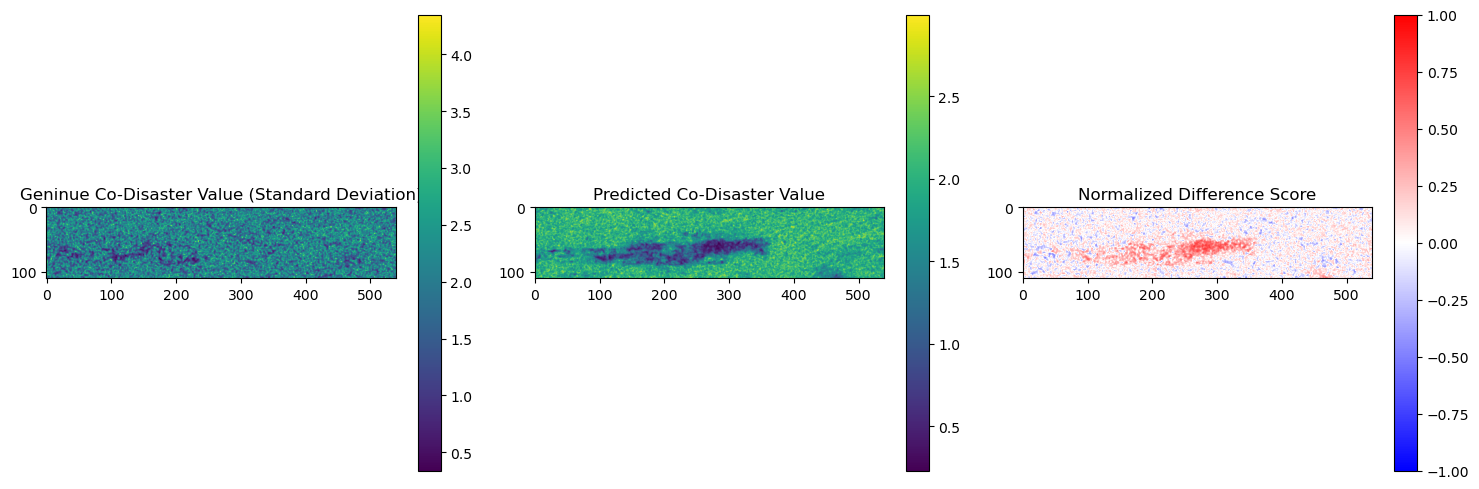

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os

# ============================================================
# 1. Function: Normalized Difference Calculation
# ============================================================
def calculate_difference(interferogram1, interferogram2, chunk_size=1024):
    """
    Compute the normalized difference between two interferograms
    with block-wise processing to reduce memory usage.
    
    Args:
        interferogram1 (np.ndarray): First interferogram (2D array).
        interferogram2 (np.ndarray): Second interferogram (2D array).
        chunk_size (int): Block size for processing to avoid memory overflow.
        
    Returns:
        np.ndarray: Difference map (float32), with NaN for invalid pixels.
    """
    if interferogram1.shape != interferogram2.shape:
        raise ValueError("Both interferograms must have the same shape.")
    
    rows, cols = interferogram1.shape
    difference = np.zeros((rows, cols), dtype=np.float32)

    chunk_rows = max(1, min(chunk_size, rows))
    chunk_cols = max(1, min(chunk_size, cols))

    for i in range(0, rows, chunk_rows):
        for j in range(0, cols, chunk_cols):
            end_i = min(i + chunk_rows, rows)
            end_j = min(j + chunk_cols, cols)

            if end_i <= i or end_j <= j:
                continue

            chunk1 = interferogram1[i:end_i, j:end_j]
            chunk2 = interferogram2[i:end_i, j:end_j]

            epsilon = 1e-8
            denominator = chunk1 + chunk2 + epsilon
            valid_mask = denominator != 0

            diff_chunk = np.full_like(chunk1, np.nan, dtype=np.float32)
            diff_chunk[valid_mask] = (chunk1[valid_mask] - chunk2[valid_mask]) / denominator[valid_mask]

            difference[i:end_i, j:end_j] = diff_chunk

    mask = np.isnan(interferogram1) | np.isnan(interferogram2) | (interferogram1 == 0) | (interferogram2 == 0)
    difference[mask] = np.nan

    return difference


# ============================================================
# 2. Load Data
# ============================================================
# Load the geninue_std.npy (geninue's standard deviation) and future_predictions.npy (predicted results)
geninue_std_path = "/data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/dataset/geninue_std.npy"
future_predictions_path = "/data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/predict/future_predictions.npy"

geninue_std = np.load(geninue_std_path)
future_predictions = np.load(future_predictions_path)

# Option 1: Convert geninue_std to 2D (if necessary)
geninue_std = np.squeeze(geninue_std, axis=-1)

# Option 2: Alternatively, you can expand future_predictions to 3D (if necessary)
# future_predictions = np.expand_dims(future_predictions, axis=-1)

print(f"Loaded geninue_std with shape {geninue_std.shape}")
print(f"Loaded future_predictions with shape {future_predictions.shape}")

# ============================================================
# 3. Compute Normalized Difference Score
# ============================================================
# Compute the normalized difference between geninue_std and future_predictions
phase_score = calculate_difference(geninue_std, future_predictions, chunk_size=512)

# Apply masking for NaN/zeros
phase_score = np.where(np.isnan(geninue_std), np.nan,
                       np.where(geninue_std == 0, 0, phase_score))
phase_score = np.where(np.isnan(future_predictions), np.nan,
                       np.where(future_predictions == 0, 0, phase_score))

print("Score map computed successfully.")

# ============================================================
# 4. Save Results
# ============================================================
# Define output file path
output_filename = "score.npy"
output_dir = "/data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/predict"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, output_filename)

# Save the score to a .npy file
np.save(output_path, phase_score)
print(f"Result saved as {output_filename}")

# ============================================================
# 5. Visualization Example
# ============================================================
# Visualization of the results
plt.figure(figsize=(15, 5))

# Geninue Co-Disaster Value (Standard Deviation)
plt.subplot(1, 3, 1)
plt.imshow(geninue_std, cmap='viridis')
plt.title("Geninue Co-Disaster Value (Standard Deviation)")
plt.colorbar()

# Predicted Co-Disaster Value (Predictions)
plt.subplot(1, 3, 2)
plt.imshow(future_predictions, cmap='viridis')
plt.title("Predicted Co-Disaster Value")
plt.colorbar()

# Normalized Difference Score
plt.subplot(1, 3, 3)
plt.imshow(phase_score, cmap="bwr", vmin=-1, vmax=1)
plt.title("Normalized Difference Score")
plt.colorbar()

plt.tight_layout()
plt.show()
